In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

/srv/conda/envs/py36/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


In [2]:
def load_hcp100_bold(path, subjects=range(1, 101)):
    """
    Loads the BOLD data of the HCP100 dataset.
    
    Parameters
    ----------
    path : str
           path to data folder

    subjects : iterable
               iterable with ids of subjects to be loaded
               by default, all 100 subjects will be loaded
             
    Returns
    -------
    data : list of 2d nd arrays
           synthetic BOLD time series (numTRs X numROIs) of n subjects
           output format matches nilearn.ConnectivityMeasure.fit_transform() input format
    """
    data = []
    for sub in subjects:
        fullfile = os.path.join(path, f"sub{sub:03}_BOLD_timeseries_HCP.csv")
        data.append(np.asarray(pd.read_csv(fullfile, header=None)).transpose())
        
    return data

def load_hcp100_dti(path, subjects=range(1, 101)):
    """
    Loads the DTI structural connectivity data of the HCP100 dataset.
    
    Parameters
    ----------
    path : str
           path to data folder

    subjects : iterable
               iterable with ids of subjects to be loaded
               by default, all 100 subjects will be loaded
             
    Returns
    -------
    data : list of 2d nd arrays
           empirical structural connectivity matrices (numROIs X numROIs) of HCP subjects
           output format matches nilearn.ConnectivityMeasure.fit_transform() input format
    """
    data = []
    for sub in subjects:
        fullfile = os.path.join(path, f"sub{sub:03}_DTI_fibers_HCP.csv")
        data.append(np.asarray(pd.read_csv(fullfile, header=None)))
        
    return data

In [3]:
# load BOLD data and structural connectivity
path = "/home/jovyan/shared/hcp_connectivity/schaefer100"
empirical_bold = load_hcp100_bold(path)
empirical_SC = load_hcp100_dti(path)
print(f"empirical BOLD data shape: {empirical_bold[0].shape}, empirical SC shape: {empirical_SC[0].shape}")

empirical BOLD data shape: (1189, 100), empirical SC shape: (100, 100)


In [4]:
# ignore nilearn warning messages
import warnings
warnings.filterwarnings("ignore", message="The default strategy for standardize is currently 'zscore'")

# compute vectorized functional connectivity matrix: numEdges x numSubs
conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
empirical_FC = conn_measure.fit_transform(empirical_bold).transpose()
print(f"empirical FC shape: {empirical_FC.shape}")

empirical FC shape: (4950, 100)


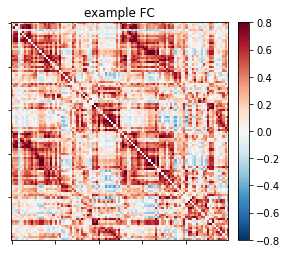

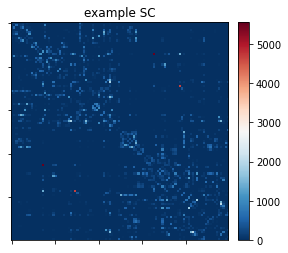

In [5]:
# plot example FC and SC
from nilearn import plotting

conn_measure2d = ConnectivityMeasure(kind='correlation', vectorize=False, discard_diagonal=False)
exampleFC = conn_measure2d.fit_transform([empirical_bold[0]]).squeeze()
np.fill_diagonal(exampleFC, 0)
exampleSC = empirical_SC[0]

fig, ax = plt.subplots();
im = plotting.plot_matrix(exampleFC, vmax=0.8, vmin=-0.8, colorbar=False, axes=ax);
plt.colorbar(im, fraction=0.05, pad=0.03);
ax.set_title("example FC");
plt.show()

fig, ax = plt.subplots();
im = plotting.plot_matrix(exampleSC, colorbar=False, axes=ax);
plt.colorbar(im, fraction=0.05, pad=0.03);
ax.set_title("example SC");
plt.show()

In [6]:
import fastdmf as dmf
from bayes_opt import BayesianOptimization, UtilityFunction
from ks_metric import ks_score

In [7]:
class BrainModel():
    """
    Whole-brain model class. As of yet, BrainModel is a DMF whole-brain model as per FastDMF.
    """
    
    def __init__(self, **kwargs):
        # FastDMF attributes
        params = kwargs.get('params', {})
        self.params = dmf.default_params(**params)
        
        # additional attributes
        self.pbounds = kwargs.get('pbounds', {'G': [0.01, 5]}) # bounds of all free model parameters as dict
        self._loss = np.inf 
        
    def get_loss(self):
        return self._loss
    
    def set_G(self, G):
        self.params['G'] = G
        
    def get_G(self):
        return self.params['G']
    
    def run(self, ms):
        """
        Returns 2d array of synthetic BOLD data where rows=seconds and cols=brain regions.
        """
        return dmf.run(self.params, ms)
    
    def testrun(self, ms, G=[], plots=[1, 1]):
        """
        synthesizes data and plots BOLD and FC connectivity matrix.
        """
        # set G 
        if G:
            original_G = self.get_G()
            self.set_G(G)
            
        # simulate data
        bold = self.run(ms)

        # plot synthetic BOLD data
        if plots[0] > 0:
            fig, ax = plt.subplots()
            im = ax.imshow(bold.transpose())
            ax.set_ylabel('time (s)');
            ax.set_xlabel('brain regions');
            ax.set_title(f"synthetic BOLD data; G = {np.round(self.get_G(), 3)}");
            plt.colorbar(im, fraction=0.03, pad=0.03);
            plt.show()

        if plots[1] > 0:
            # compute and plot FC
            conn_measure = ConnectivityMeasure(kind='correlation', vectorize=False, discard_diagonal=False)
            FC = conn_measure.fit_transform([bold.transpose()]).squeeze()
            np.fill_diagonal(FC, 0)

            fig, ax = plt.subplots();
            scaling = np.max(FC) if np.max(FC)>(-np.min(FC)) else (-np.min(FC))
            im = plotting.plot_matrix(FC, vmax=scaling, vmin=-scaling, colorbar=False, axes=ax);
            plt.colorbar(im, fraction=0.05, pad=0.03);
            ax.set_title(f"synthetic FC; G = {np.round(self.get_G(), 3)}");
            plt.show()
            
        # set G back to original value    
        if G:
            self.set_G(original_G)
            
    def utility(self, empirical_FC, ms = 120000):
        """ 
        Computes negative loss of DMF whole-brain model fit to empirical functioncal connectivity data.

        Parameters
        ----------
        empirical_FC : 0D array
                       vectorized lower/ upper triangular empirical functional connectivity matrix
                       should NOT contain self-correlation values of regional timeseries with themselves
        
        G : float
            global coupling parameter G
            if given, model will run with a different G parameter than self.params['G']

        ms : int
             number of milisecond time steps of bold data to be synthesized for fitting

        Returns
        -------
        result : float
                 negative loss; negative ks-distance between functional connectivity value 
                 distributions of synthesized versus empirical data
        """

        # simulate BOLD data
        bold = self.run(ms)

        # get functional connectivity of unique pairs of model-brain regions
        FC_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
        synthetic_FC = FC_measure.fit_transform([np.transpose(bold)]).flatten()

        # check dimensions of input (TODO: perform check before running simulation)
        assert len(synthetic_FC) == len(empirical_FC), f"empirical_FC must have the shape {synthetic_FC.shape}."

        # return ks-distance between synthetic and empirical functional connectivity distributions
        category = np.concatenate((np.zeros(len(synthetic_FC)), np.ones(len(empirical_FC))), axis=0)
        stacked_data = np.concatenate((synthetic_FC, empirical_FC), axis=0)
        ks_dist = ks_score(category, stacked_data)
        return -ks_dist
    
    def _evaluate_clone(self, empirical_FC, G, ms = 120000):
        # make clone
        clone = BrainModel(**self.__dict__)
        # change G
        clone.params['G'] = G
        # evaluate clone
        return clone.utility(empirical_FC, ms=ms)

    def fit(self, empirical_FC, ms=120000, init_points=5, n_iter=10):
        """
        Uses Bayesian Optimization to find optimal model parameters so as to fit DMF whole-brain 
        model to empirical data.

        Parameters
        ----------
        empirical_FC : 0D array
                       vectorized lower/ upper triangular empirical functional connectivity matrix
                       should NOT contain self-correlation values of regional timeseries with themselves
                       
        ms : int
             number of milisecond time steps of bold data to be synthesized for fitting
             
        init_points : int
                      number of sampled model parameters to be evaluated at each iteration
                      
        n_iter : int
                 number of iterations
        """
        # create BayesianOptimization optimizer and maximize utility
        optimizer = BayesianOptimization(f = lambda G: self._evaluate_clone(empirical_FC, G, ms=ms), 
                                         pbounds = self.pbounds)
        optimizer.maximize(init_points = init_points, n_iter = n_iter)
        
        # update model parameter and loss
        self.set_G(optimizer.max['params']['G'])
        self._loss = optimizer.max['target']

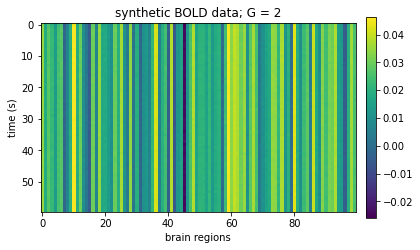

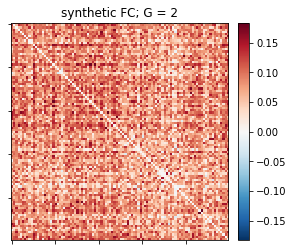

In [8]:
# test run the consensus structural connectivity
ms = 120000
model = BrainModel()
model.testrun(ms)

In [9]:
# test: fit model to empirical FC of random subject
import time

exampleSub = 29

start = time.time()
model = BrainModel(C=empirical_SC[exampleSub])
model.fit(empirical_FC[:, exampleSub], ms=120000, init_points=5, n_iter=50)
end = time.time()
print(f"time passed: {(end-start)/60} minutes.")

|   iter    |  target   |     G     |
-------------------------------------
| 1         | -53.62    | 4.565     |
| 2         | -50.4     | 2.345     |
| 3         | -45.82    | 1.952     |
| 4         | -52.28    | 3.166     |
| 5         | -31.7     | 1.826     |
| 6         | -28.61    | 1.777     |
| 7         | -52.42    | 3.298     |
| 8         | -49.31    | 1.538     |
| 9         | -50.95    | 0.01      |
| 10        | -48.14    | 1.701     |
| 11        | -37.05    | 1.952     |
| 12        | -32.38    | 1.777     |
| 13        | -28.67    | 1.777     |
| 14        | -30.71    | 1.826     |
| 15        | -39.37    | 1.953     |
| 16        | -40.77    | 1.825     |
| 17        | -26.51    | 1.776     |
| 18        | -27.11    | 1.776     |
| 19        | -37.05    | 1.776     |
| 20        | -29.94    | 1.826     |
| 21        | -30.65    | 1.827     |
| 22        | -29.43    | 1.826     |
| 23        | -42.75    | 1.827     |
| 24        | -36.87    | 1.912     |
| 25        

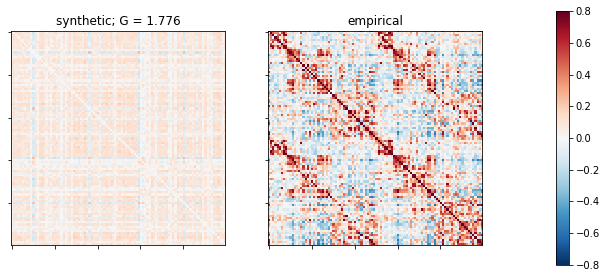

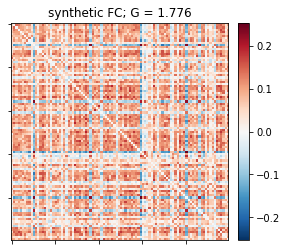

In [10]:
# visual assessment of model fit

# synthesize BOLD data
timesteps = 120000 # miliseconds
bold = model.run(timesteps)

# compute synthetic FC
FCsynth = conn_measure2d.fit_transform([bold.transpose()]).squeeze()
np.fill_diagonal(FCsynth, 0)

# compute empirical FC of sub0
FCemp = conn_measure2d.fit_transform([empirical_bold[exampleSub]]).squeeze()

# plot synthetic and empirical FC next to each other
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 22));
plotting.plot_matrix(FCsynth, vmax=0.8, vmin=-0.8, colorbar=False, axes=ax0);
plotting.plot_matrix(FCemp, vmax=0.8, vmin=-0.8, colorbar=True, axes=ax1);
ax0.set_title(f"synthetic; G = {np.round(model.get_G(), 3)}");
ax1.set_title('empirical');

# plot synthetic once again with different colour range
fig, ax = plt.subplots();
scaling = np.max(FCsynth) if np.max(FCsynth)>(-np.min(FCsynth)) else (-np.min(FCsynth))
im = plotting.plot_matrix(FCsynth, vmax=scaling, vmin=-scaling, colorbar=False, axes=ax);
plt.colorbar(im, fraction=0.05, pad=0.03);
ax.set_title(f"synthetic FC; G = {np.round(model.get_G(), 3)}");
plt.show()

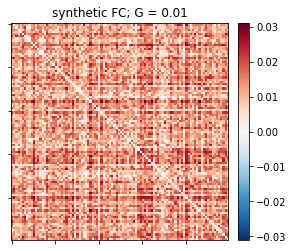

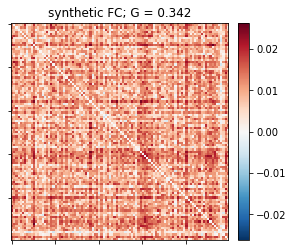

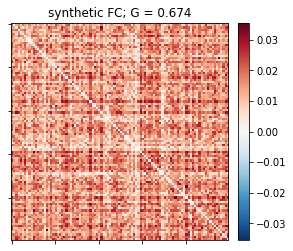

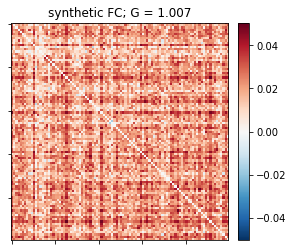

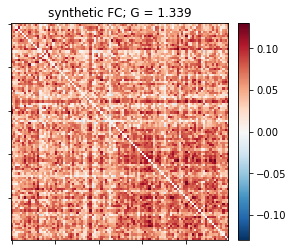

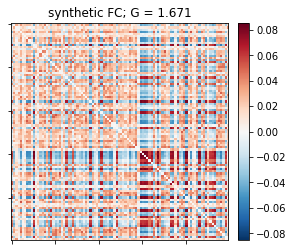

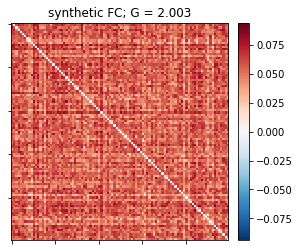

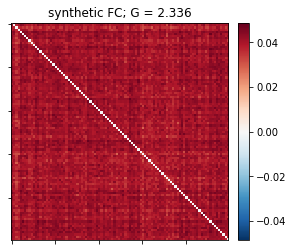

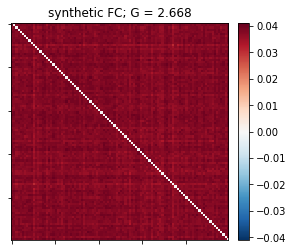

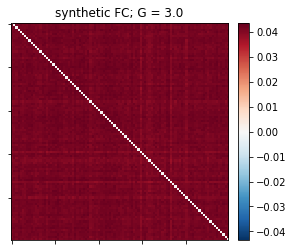

In [11]:
# try a range of different Gs for exampleSub
ms = 120000
Gs = np.linspace(0.01, 3, 10)
for g in Gs:
    model = BrainModel(C=empirical_SC[exampleSub])
    model.testrun(ms, G=g, plots=[0,1])